### The purpose of this notebook is to compare and explore different imputation methods - it is not involved in the actual pipeline of the project

In [1]:
from imputation_utils import *

# Import data

In [2]:
data, VARIABLES = import_data(discard_variables=True, discard_days=True, THRESHOLD=60)

discarded variables: ['GalvanicSkinResponse', 'ActivityClass']
discarded days (less than 60min of data): [312]
discarded days (sensor out all day): [114]


# Imputation

Format data into daily dataframes (for imputation model)

In [3]:
data_daily = data_to_days(data)

100%|██████████| 408/408 [02:02<00:00,  3.32it/s]


Normalize day-variable-wise

In [4]:
normalize_by_day(data_daily)

day 0 - ActivityCounts: mean: 1.2688263138573217e-17, std: 0.9999999999999959
day 0 - Barometer: mean: -5.938107148852266e-14, std: 0.9999999999999997
day 0 - BloodPerfusion: mean: 2.3770417019099194e-16, std: 1.000000000000001
day 0 - BloodPulseWave: mean: 1.092154295472125e-16, std: 1.0000000000000004
day 0 - EnergyExpenditure: mean: -5.075305255429287e-17, std: 1.0000000000000064
day 0 - HR: mean: -9.765144288927236e-16, std: 1.0
day 0 - HRV: mean: 1.5650721051984586e-16, std: 0.9999999999999997
day 0 - RESP: mean: -3.760906729921135e-16, std: 0.9999999999999998
day 0 - Steps: mean: -3.6478756523398e-17, std: 0.9999999999999938
day 0 - SkinTemperature: mean: 2.816794416763254e-15, std: 0.999999999999999
day 1 - ActivityCounts: mean: 0.0, std: 0.9999999999999909
day 1 - Barometer: mean: 7.088903107932162e-14, std: 0.9999999999999981
day 1 - BloodPerfusion: mean: -3.120978341552417e-17, std: 0.9999999999999994
day 1 - BloodPulseWave: mean: 6.241956683104833e-17, std: 0.999999999999999

### Explore imputation methods

In [5]:
# choose day
day = 400
data_day = data_daily[day]

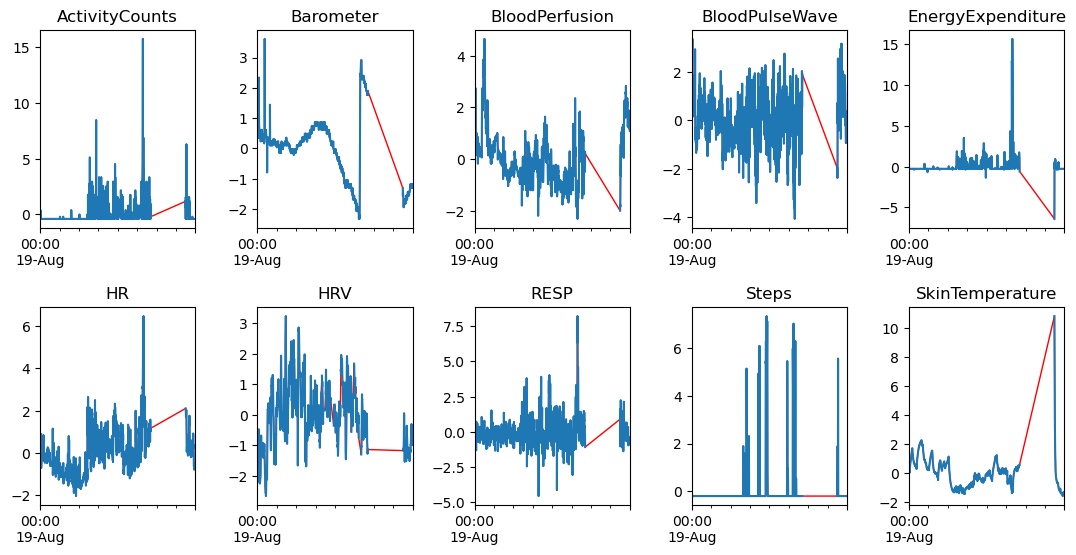

In [6]:
visualize_imputation(data_day, 'linear')

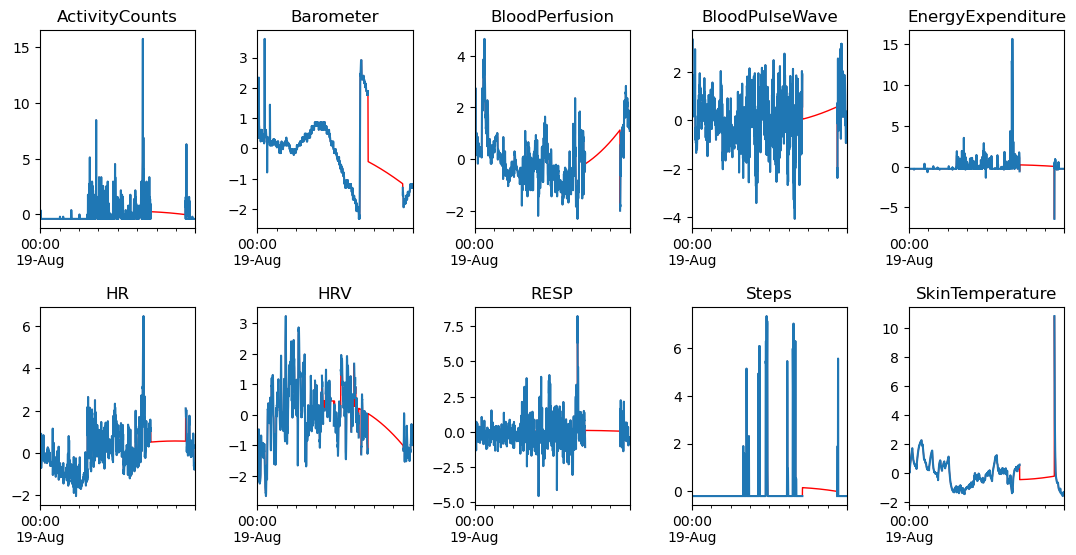

In [7]:
visualize_imputation(data_day, 'spline', order=2)

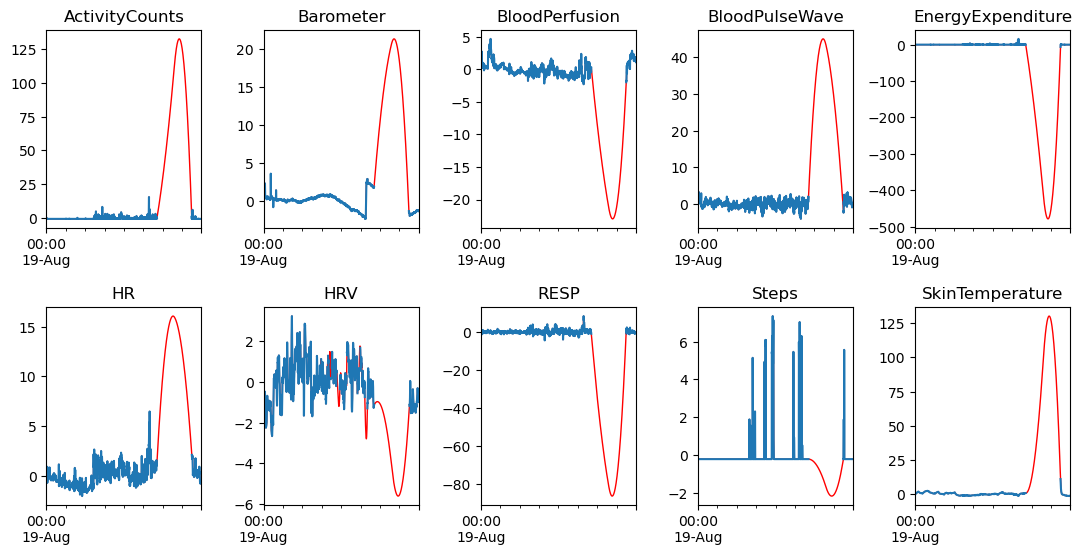

In [8]:
visualize_imputation(data_day, 'quadratic')

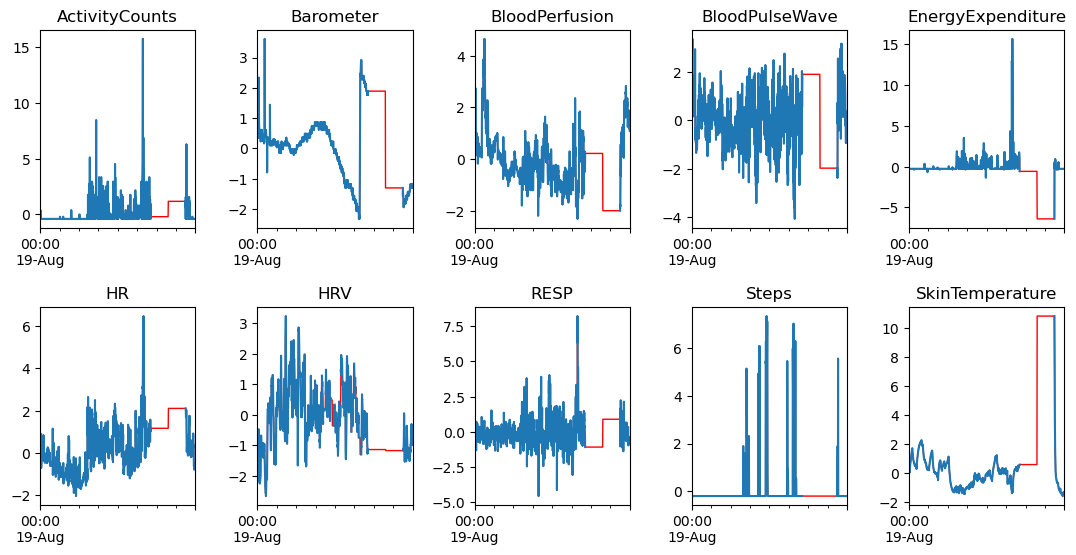

In [9]:
visualize_imputation(data_day, 'nearest')

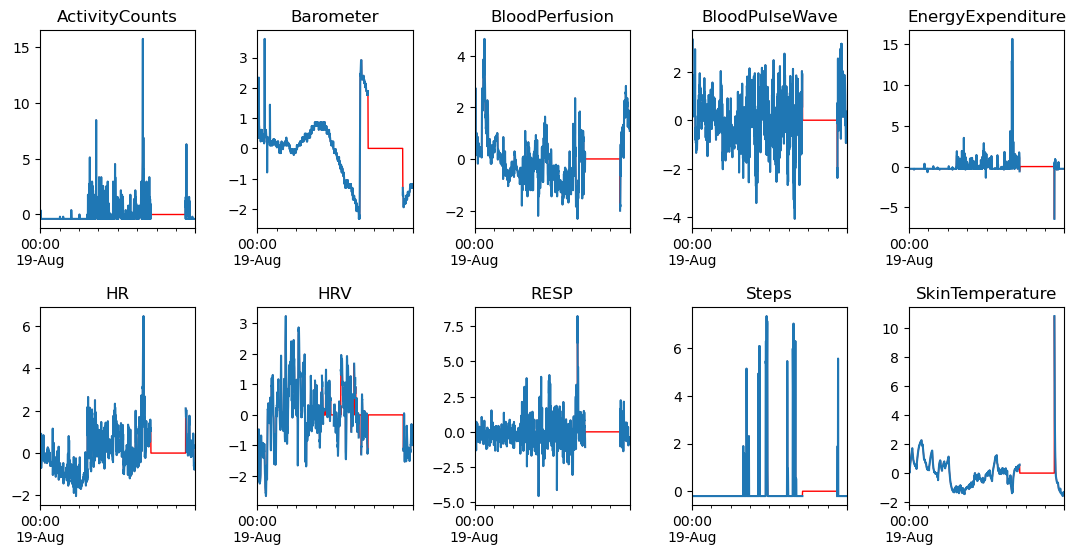

In [10]:
visualize_imputation(data_day, 'mean')

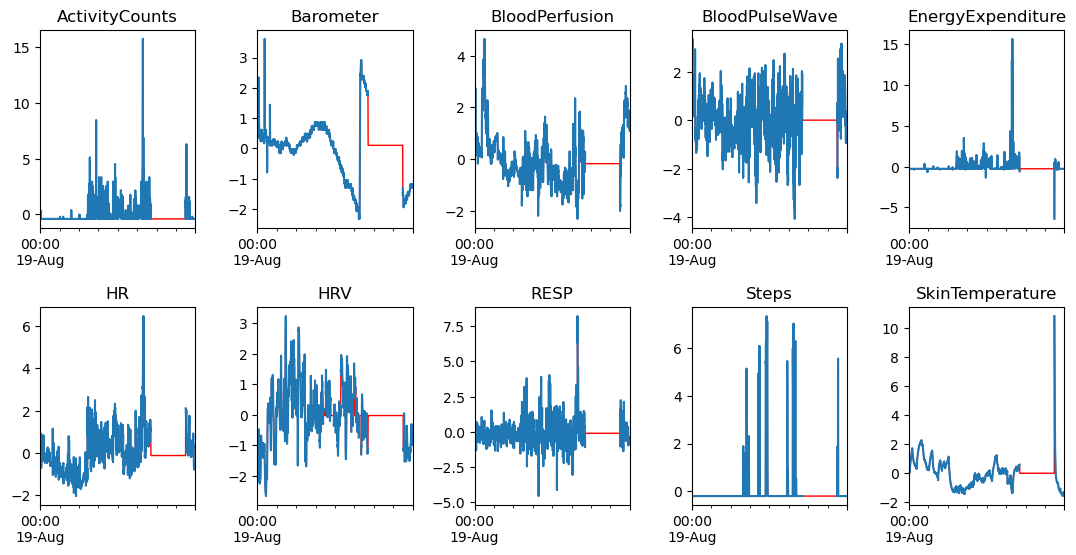

In [11]:
visualize_imputation(data_day, 'median')

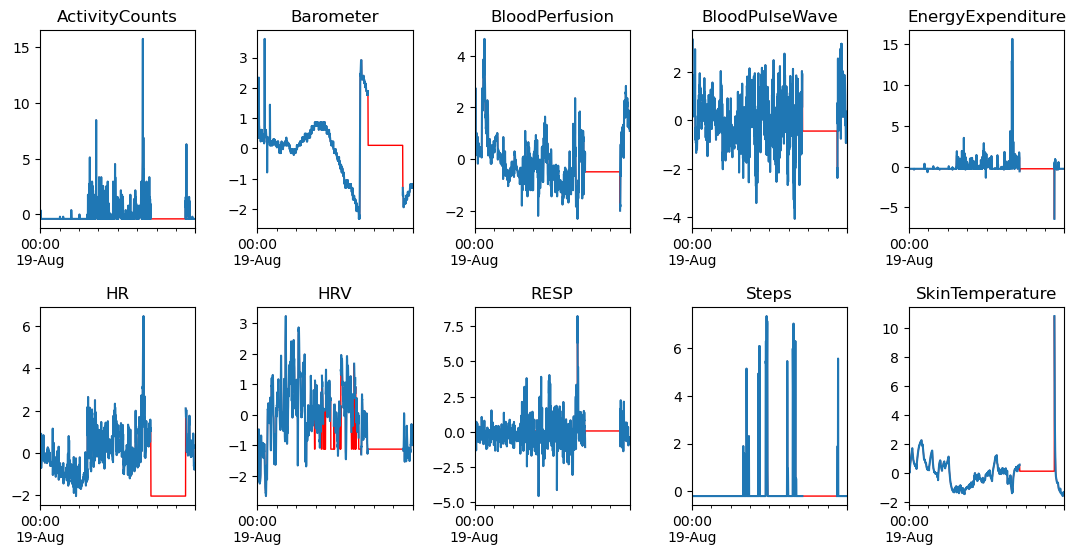

In [12]:
visualize_imputation(data_day, 'mode')

Note: general problem are long missing sequences, e.g.:

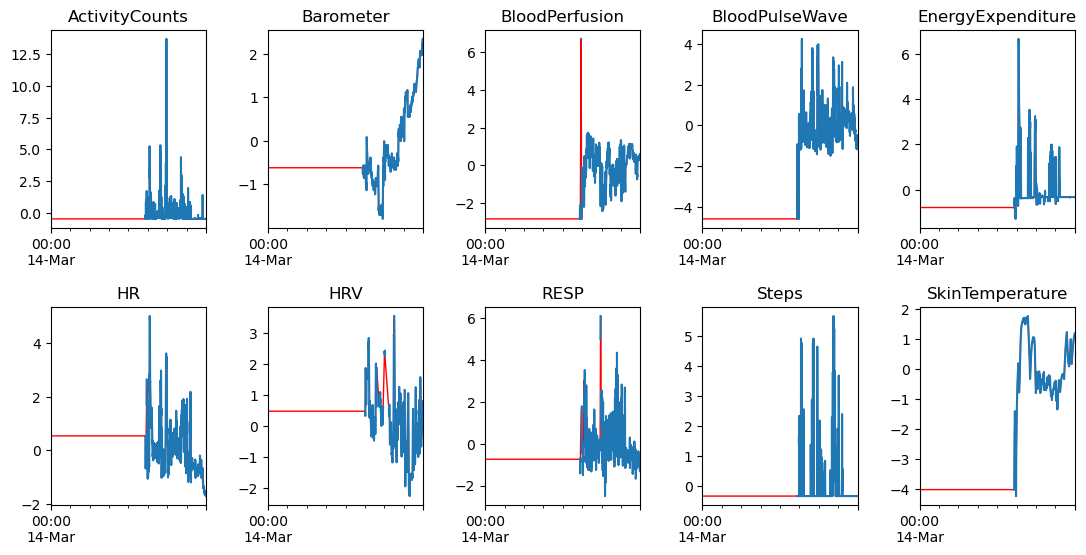

In [13]:
visualize_imputation(data_daily[0], 'linear')

### Scoring of methods

Visualize mask

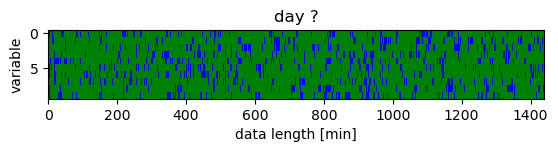

In [54]:
mask = masker(data_day, lm=3, masking_ratio=0.15)
visualize_mask(mask)

Numerical analysis

In [17]:
# short sequences
test_imputation_methods(data_daily, lm=3, masking_ratio=0.15)

[('linear', (0.2961292870438904, 0.0012682778780982533)),
 ('nearest', (0.31782201184574554, 0.001361184605617536)),
 ('quadratic', (0.45839719304728455, 0.0019632472867772708)),
 ('spline', (0.5595774404830617, 0.0023965873012159107)),
 ('median', (0.6141043227300564, 0.0026301178621606714)),
 ('mean', (0.7001167373315408, 0.002998496295006152)),
 ('mode', (0.789170780174581, 0.0033799015711290163))]

In [21]:
# long sequences
test_imputation_methods(data_daily, lm=200, masking_ratio=0.15)

[('spline', (0.6965643814075183, 0.003312635568380723)),
 ('mean', (0.8726121899906409, 0.004149862173722675)),
 ('median', (0.8888592057215736, 0.004227127741166097)),
 ('mode', (1.1733940265204985, 0.0055802835914792615)),
 ('linear', (1.6051672975347757, 0.007633658029241672)),
 ('nearest', (1.7186798249356803, 0.008173487003794187)),
 ('quadratic', (4134.104109745407, 19.660465971083813))]

### Calculate mean sequence length & masking ratio in actual data

Mean sequence length: lm

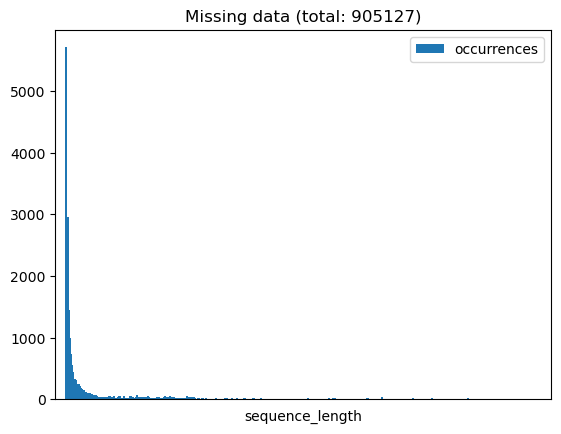

In [45]:
na_seqs = na_sequence_lengths(data)

In [46]:
na_distribution = [[seq_length]*occurence for seq_length, occurence in na_seqs.to_numpy()]
na_distribution = [element for sublist in na_distribution for element in sublist]

In [47]:
lm = np.mean(na_distribution) # mean masked sequence
lm

43.43845083265345

Masking ratio: masking_ratio

In [48]:
# NaN -> 1.0, available data -> NaN
na_flipped = data.copy(deep=True)
n_days, _ = na_flipped.shape
for day in range(n_days):
    for variable in VARIABLES:
        time_series = get_time_series(na_flipped, variable, day)
        nas = np.isnan(time_series)
        time_series[:] = 1.0 # set full array to 1.0
        time_series[~nas] = np.NaN # set all elements that weren't NaN to NaN

        na_flipped[variable].iloc[day] = time_series

/var/folders/tq/31s58g8x49x32phm81cky_s40000gn/T/ipykernel_35668/2278000663.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_flipped[variable].iloc[day] = time_series


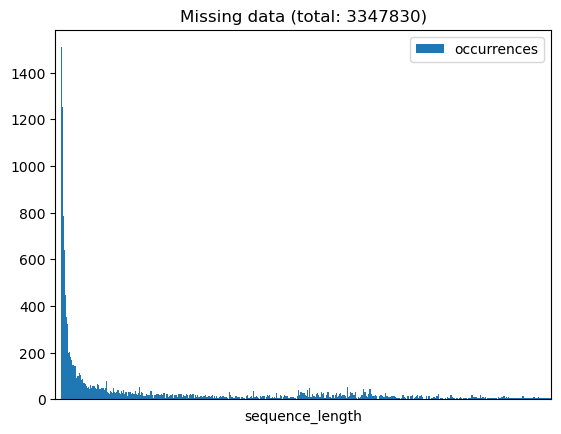

In [49]:
non_na_seqs = na_sequence_lengths(na_flipped)

In [50]:
non_na_distribution = [[seq_length]*occurence for seq_length, occurence in non_na_seqs.to_numpy()]
non_na_distribution = [element for sublist in non_na_distribution for element in sublist]

In [51]:
np.mean(non_na_distribution) # mean unmasked sequence

161.50465531381155

In [52]:
r = lm / (np.mean(non_na_distribution) + lm) # masking_ratio
r

0.21195370583292347

Visualize

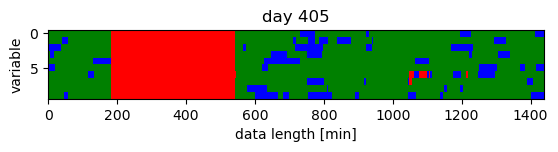

In [53]:
visualize_mask(masker(data_day, lm=lm, masking_ratio=r))

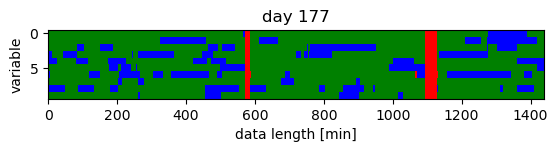

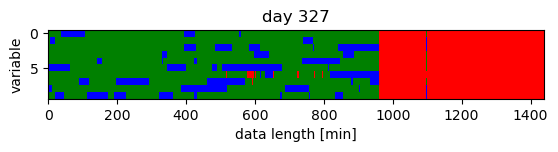

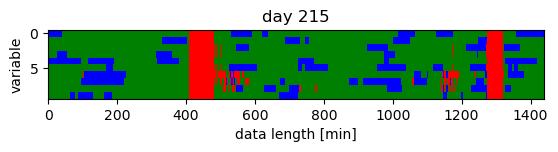

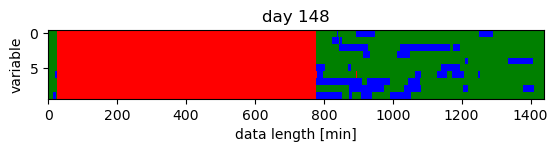

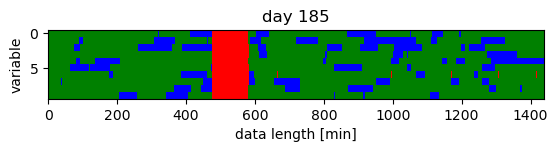

In [54]:
for i in range(5):
    day = np.random.choice(n_days, 1)[0]
    visualize_mask(masker(data_daily[day], lm=lm, masking_ratio=r))

## Test on actual mean of data

In [57]:
test_imputation_methods(data_daily, lm=lm, masking_ratio=r)

[('nearest', (0.5083644934234958, 0.001839382851107746)),
 ('linear', (0.5230483201522551, 0.001892512405635893)),
 ('spline', (0.5432733990534853, 0.001965691519784278)),
 ('median', (0.5602454942578904, 0.0020271005703183095)),
 ('mode', (0.5762568469234104, 0.002085033427347059)),
 ('mean', (0.6300930530372725, 0.0022798255412251737)),
 ('quadratic', (19.49417889525959, 0.0705345452332682))]

# Transformer imputation

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
def plotter_from_array(dat):
    """
    Same as plotter(day, dat) but here dat is array of daily data (shape: [1, 1440, 10])
    """
    if not isinstance(dat, np.ndarray):
        dat = dat.detach().numpy()

    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    batch_size, length, variables = dat.shape
    assert batch_size == 1 and length == 1440 and variables == 10

    # TODO: not sure if correct VARIABLES if we discard in import
    for i, variable in enumerate(VARIABLES):
        time_series = dat[:, :, i].reshape(-1)

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series)
        plt.xlim([0, length])

Transformer model

In [13]:
# TODO: check parameters
model = TSTransformerEncoder(feat_dim=len(VARIABLES),
                             max_len=1440,
                             d_model=256,
                             n_heads=4,
                             num_layers=1,
                             dim_feedforward=256,
                             dropout=0.1,
                             pos_encoding='fixed',
                             activation='gelu',
                             norm='BatchNorm',
                             freeze=False)

model = model.to(device)

In [14]:
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=256, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(256, eps=1e-05, momen

In [15]:
sum(p.numel() for p in model.parameters()) # TODO: less params (?) (or pruning afterwards?)

401162

Data

In [16]:
# train-test split (TODO: + val?)
from sklearn.model_selection import train_test_split

n_days = len(data_daily)
train_indices, test_indices = train_test_split(np.arange(n_days))

Training model

In [17]:
# mask on-the-fly? -> model sees more data

In [18]:
criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# TODO: for now use batch_size = 1
# TODO: use dataloader?
# TODO: on GPU?
# TODO: evaluate only on purposefully set to NaN?
epochs = 50

model.train() # set model into training mode

history = {'train_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in range(epochs):
    # loss, metrics
    epoch_loss = 0.0

    # batches
    for i, batch_index in enumerate(tqdm(train_indices)):
        # load training batch
        batch = data_daily[batch_index].copy()

        # create mask (on-the-fly) # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
        mask = masker(batch, lm=43, masking_ratio=0.21)

        # reshape
        mask = mask.transpose()
        batch = batch.transpose().to_numpy() # pandas -> numpy + reshape

        # mask missing data
        y_true = torch.tensor(batch).unsqueeze(0).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).unsqueeze(0).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        y_pred = model(X, padding_masks=torch.ones(1, 1440).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss)

    # print
    print(f'Epochs {epoch + 1}/{epochs} - loss: {epoch_loss}')

Starting training for 50 epochs


100%|██████████| 306/306 [00:12<00:00, 23.63it/s]


Epochs 1/50 - loss: 408.7748664021492


100%|██████████| 306/306 [00:11<00:00, 27.08it/s]


Epochs 2/50 - loss: 620.8228704929352


100%|██████████| 306/306 [00:11<00:00, 27.39it/s]


Epochs 3/50 - loss: 1329.815705895424


100%|██████████| 306/306 [00:11<00:00, 27.41it/s]


Epochs 4/50 - loss: 1125.3555198907852


100%|██████████| 306/306 [00:11<00:00, 27.02it/s]


Epochs 5/50 - loss: 1291.95598590374


 21%|██        | 63/306 [00:02<00:08, 27.37it/s]

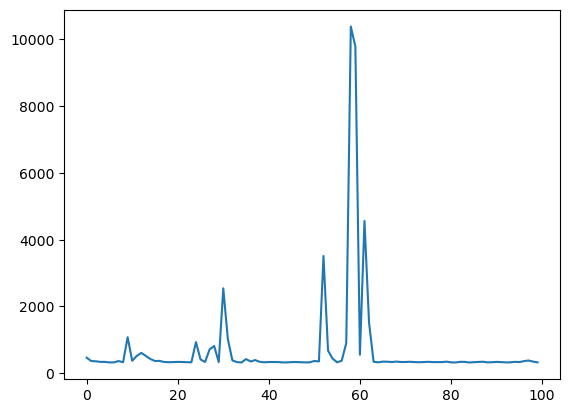

In [44]:
plt.plot(history['train_loss'])

Evaluation model

In [39]:
test_input = data_day.copy().transpose().to_numpy()
nan_mask = np.isnan(test_input)
test_input[nan_mask] = 0.0 # mask -> 0.0
test_input = torch.tensor(test_input, dtype=float).unsqueeze(0)
test_input, test_input.shape

(tensor([[[-0.3919,  0.3567,  0.4512,  ...,  0.3112, -0.2036,  0.1634],
          [-0.3919,  0.4206,  0.2137,  ..., -0.5609, -0.2036,  0.1323],
          [ 0.3937,  0.4845,  0.2137,  ..., -0.5542, -0.2036,  0.1323],
          ...,
          [-0.3919, -1.1767,  1.2428,  ..., -0.7088, -0.2036, -1.2985],
          [-0.3919, -1.3045,  1.0844,  ..., -0.7708, -0.2036, -1.2985],
          [-0.3919, -1.3045,  1.0844,  ..., -0.7343, -0.2036, -1.2985]]],
        dtype=torch.float64),
 torch.Size([1, 1440, 10]))

In [40]:
# TODO: do we need padding? AFAIK all our sequences are 1440 long
'''model(test_input.float(), padding_masks=torch.ones(1, 1440).bool())'''

'model(test_input.float(), padding_masks=torch.ones(1, 1440).bool())'

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

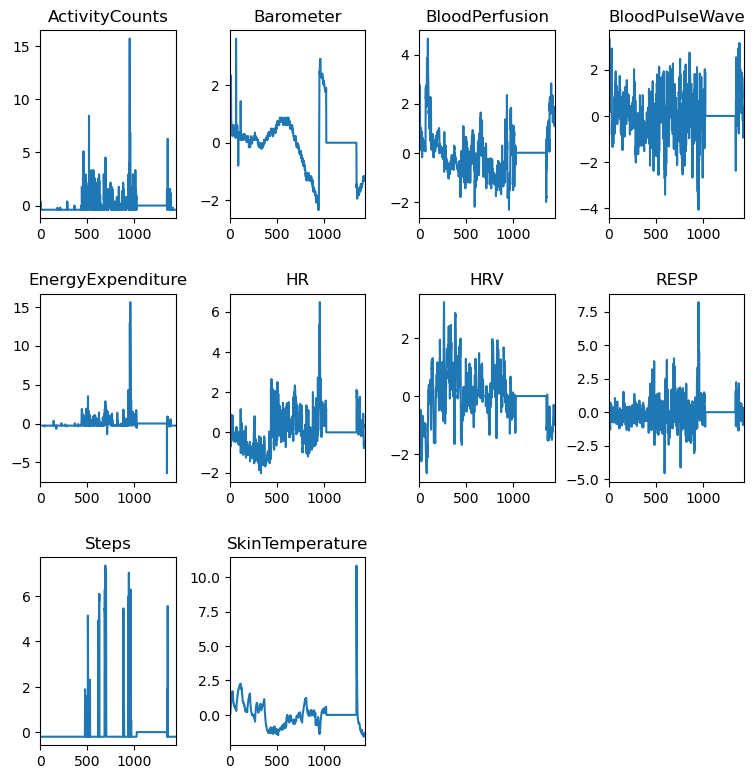

In [43]:
# visualize
plotter_from_array(test_input)
plotter_from_array(model(test_input.float(), padding_masks=torch.ones(1, 1440).bool().to(device)))